<h2><center>AI in Healthcare</center></h2>
<h3><center>NLP for Health-care Data</h3>

The objective of this lab is to learn how to fine-tune a pre-trained llm for a specific healthcare aplication task.
    
This assignment has 3 sections:
    
    * pre-processing  the clinical text for LLM
    * few-shot in-context learning on LLM
    * fine-tuning the llm
    * parameter efficient fine tuning (PEFT) on LLM

# **data preparation**

### Download data and T5 model from physionet.org



In [1]:
!pip install tensorflow matplotlib
!pip install evaluate
!pip install rouge_score

In [2]:
#Loading modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import os 
import sys
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from tqdm import tqdm
import re

In [3]:
###Pre-process clinical text
#do zero-shotlearning,1, ..., 5 shot incontext-learning
#fine-tune the llm for maximum 5 epochs
#peft with LORA

#evaluation based on loss training, validation, test and rouge_score on test dataset

### Loading data

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!python --version

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU detected.")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Python 3.11.5
cuda:0
GPU is available.


In [5]:

NOTEEVENTS = pd.read_csv("C:/Users/danie/Documents/SKOLA/HÄLSA 3/mimic-iii-clinical-database-1.4/mimic-iii-clinical-database-1.4/NOTEEVENTS.csv.gz")

C:\Users\danie\AppData\Local\Temp\ipykernel_19152\2767236405.py:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  NOTEEVENTS = pd.read_csv("C:/Users/danie/Documents/SKOLA/HÄLSA 3/mimic-iii-clinical-database-1.4/mimic-iii-clinical-database-1.4/NOTEEVENTS.csv.gz")


In [6]:
NOTEEVENTS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [7]:
print(NOTEEVENTS.shape)

(2083180, 11)


In [8]:
NOTEEVENTS_discharge = NOTEEVENTS.loc[NOTEEVENTS.CATEGORY == "Discharge summary"]

In [9]:
unique_categories = NOTEEVENTS['CATEGORY'].unique()
print(unique_categories)

['Discharge summary' 'Echo' 'ECG' 'Nursing' 'Physician ' 'Rehab Services'
 'Case Management ' 'Respiratory ' 'Nutrition' 'General' 'Social Work'
 'Pharmacy' 'Consult' 'Radiology' 'Nursing/other']


In [10]:
NOTEEVENTS_discharge.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [11]:
print(NOTEEVENTS_discharge.shape)

(59652, 11)


In [12]:
diags = pd.read_csv("C:/Users/danie/Documents/SKOLA/HÄLSA 3/mimic-iii-clinical-database-1.4/mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv.gz")

In [13]:
diags.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [14]:
print(diags.shape)

(651047, 5)


In [15]:
desc_diags = pd.read_csv("C:/Users/danie/Documents/SKOLA/HÄLSA 3/mimic-iii-clinical-database-1.4/mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv.gz")

In [16]:
desc_diags.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [17]:
print(desc_diags.shape)

(14567, 4)


### Data preparation 

In [18]:
diags_plus_descript = pd.merge(diags, desc_diags, on="ICD9_CODE")

In [19]:
diags_plus_descript.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y,SHORT_TITLE,LONG_TITLE
0,1297,109,172335,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
1,1311,109,173633,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
2,1019,109,131345,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
3,1039,109,131376,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
4,1059,109,135923,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."


In [20]:
diags_codes_aggr = diags_plus_descript.groupby('HADM_ID')[['ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE']].agg(' , '.join).reset_index()

In [21]:
diags_codes_aggr.head()

,HADM_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,100001,"5849 , 40390 , 5853 , V5867 , 5780 , 25063 , 2...","Acute kidney failure NOS , Hy kid NOS w cr kid...","Acute kidney failure, unspecified , Hypertensi..."
1,100003,"53100 , 4019 , 5715 , 07054 , 2851 , 45621 , 5...","Ac stomach ulcer w hem , Hypertension NOS , Ci...","Acute gastric ulcer with hemorrhage, without m..."
2,100006,"486 , 2761 , V1582 , 51881 , 20300 , V1251 , 4...","Pneumonia, organism NOS , Hyposmolality , Hist...","Pneumonia, organism unspecified , Hyposmolalit..."
3,100007,"486 , 4019 , 5570 , 56081","Pneumonia, organism NOS , Hypertension NOS , A...","Pneumonia, organism unspecified , Unspecified ..."
4,100009,"2859 , 41401 , 4111 , 2720 , 4019 , 25000 , 44...","Anemia NOS , Crnry athrscl natve vssl , Interm...","Anemia, unspecified , Coronary atherosclerosis..."


In [22]:
NOTEEVENTS_plus_icds = pd.merge(NOTEEVENTS_discharge, diags_codes_aggr, on="HADM_ID")

In [23]:
NOTEEVENTS_plus_icds.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...,"4254 , 2762 , 5119 , 2639 , 42731 , 5070 , 211...","Prim cardiomyopathy NEC , Acidosis , Pleural e...","Other primary cardiomyopathies , Acidosis , Un..."
1,170,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...,"4254 , 2762 , 5119 , 2639 , 42731 , 5070 , 211...","Prim cardiomyopathy NEC , Acidosis , Pleural e...","Other primary cardiomyopathies , Acidosis , Un..."
2,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...,"486 , 2761 , 2449 , 49121 , 311 , 51881","Pneumonia, organism NOS , Hyposmolality , Hypo...","Pneumonia, organism unspecified , Hyposmolalit..."
3,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...,"2762 , 496 , 5533 , 45340","Acidosis , Chr airway obstruct NEC , Diaphragm...","Acidosis , Chronic airway obstruction, not els..."
4,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...,"2762 , 45829 , 41401 , 4019 , E9320 , 5849 , 2...","Acidosis , Iatrogenc hypotnsion NEC , Crnry at...","Acidosis , Other iatrogenic hypotension , Coro..."


In [24]:
discharge_notes_list = []
coresponding_diseases = []
for index, row in tqdm(NOTEEVENTS_plus_icds.iterrows()):
    discharge_notes_list.append(" ".join(row["TEXT"].split()[:]))
    coresponding_diseases.append(row["LONG_TITLE"][:])

dischrge_diseases_df = pd.DataFrame({"text": discharge_notes_list, "labels":coresponding_diseases})
dischrge_diseases_df.head()

59644it [00:08, 6774.65it/s]


,text,labels
0,Admission Date: [**2151-7-16**] Discharge Date...,"Other primary cardiomyopathies , Acidosis , Un..."
1,Admission Date: [**2151-7-16**] Discharge Date...,"Other primary cardiomyopathies , Acidosis , Un..."
2,Admission Date: [**2118-6-2**] Discharge Date:...,"Pneumonia, organism unspecified , Hyposmolalit..."
3,Admission Date: [**2119-5-4**] Discharge Date:...,"Acidosis , Chronic airway obstruction, not els..."
4,Admission Date: [**2124-7-21**] Discharge Date...,"Acidosis , Other iatrogenic hypotension , Coro..."


In [25]:
len_sents = []
for index, row in tqdm(dischrge_diseases_df.iterrows()):
    len_sents.append(len(row.text.split(" ")))

59644it [00:06, 8709.98it/s]


<Axes: ylabel='Frequency'>

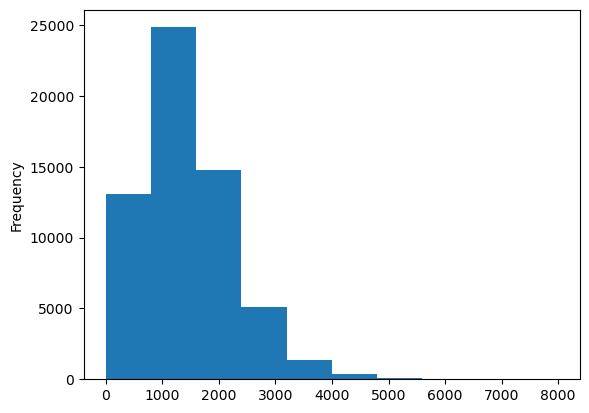

In [26]:
pd.Series(len_sents).plot.hist()

In [27]:
dischrge_diseases_df_short = dischrge_diseases_df[
    dischrge_diseases_df['text'].apply(
        lambda x: len(x.split(' ')) < 900 and len(x.split(' '))>400)]

In [28]:
dischrge_diseases_df.shape, dischrge_diseases_df_short.shape

((59644, 2), (11002, 2))

In [29]:
dischrge_diseases_df_short

,text,labels
7,Admission Date: [**2112-12-8**] Discharge Date...,"Pneumonia, organism unspecified , Congestive h..."
9,Admission Date: [**2118-8-10**] Discharge Date...,"Cerebral edema , Epilepsy, unspecified, withou..."
15,Admission Date: [**2199-2-8**] Discharge Date:...,"Thrombocytopenia, unspecified , Congestive hea..."
20,Admission Date: [**2130-2-3**] Discharge Date:...,"Unspecified essential hypertension , Atrial fi..."
28,"Name: [**Known lastname 208**],[**Known firstn...","Congestive heart failure, unspecified , Unspec..."
...,...,...
59623,"Name: [**Known lastname 9756**], [**Known firs...",Coronary atherosclerosis of native coronary ar...
59625,"Name: [**Known lastname **], [**Known firstnam...","Alcohol abuse, unspecified , Open wound of lip..."
59626,"Name: [**Known lastname **], [**Known firstnam...","Alcohol abuse, unspecified , Open wound of lip..."
59640,"Name: [**Known lastname 14938**], [**Known fir...",Coronary atherosclerosis of native coronary ar...


# Data preprocessing:

In [30]:
#student task1
#exclude all not-informative tokens and numbers from "dischrge_diseases_df_short" table (text column)
# save the tale again in "dischrge_diseases_df_short" as before

In [31]:
def preprocess_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = text.lower()
    return text

dischrge_diseases_df_short['text'] = dischrge_diseases_df_short['text'].apply(preprocess_text)
dischrge_diseases_df_short.to_csv('dischrge_diseases_df_short.csv', index=False)

C:\Users\danie\AppData\Local\Temp\ipykernel_19152\3366959172.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dischrge_diseases_df_short['text'] = dischrge_diseases_df_short['text'].apply(preprocess_text)


In [32]:
dischrge_diseases_df_short

,text,labels
7,admission date discharge date service medici...,"Pneumonia, organism unspecified , Congestive h..."
9,admission date discharge date date of birth ...,"Cerebral edema , Epilepsy, unspecified, withou..."
15,admission date discharge date date of birth ...,"Thrombocytopenia, unspecified , Congestive hea..."
20,admission date discharge date date of birth ...,"Unspecified essential hypertension , Atrial fi..."
28,name known lastname 208known firstname h unit...,"Congestive heart failure, unspecified , Unspec..."
...,...,...
59623,name known lastname known firstname unit no ...,Coronary atherosclerosis of native coronary ar...
59625,name known lastname known firstname unit no ...,"Alcohol abuse, unspecified , Open wound of lip..."
59626,name known lastname known firstname unit no ...,"Alcohol abuse, unspecified , Open wound of lip..."
59640,name known lastname known firstname t unit n...,Coronary atherosclerosis of native coronary ar...


### Convert pandasdataframe to dataset object

In [33]:
import transformers
from datasets import load_dataset, Dataset, DatasetDict

trainds = Dataset.from_pandas(dischrge_diseases_df_short.iloc[:6000])
valds = Dataset.from_pandas(dischrge_diseases_df_short.iloc[6000:9000])
testds = Dataset.from_pandas(dischrge_diseases_df_short.iloc[9000:])

dataset = DatasetDict()

dataset['train'] = trainds
dataset['validation'] = valds
dataset['test'] = testds

In [34]:
print("Train dataset shape:", dataset['train'].shape)
print("Validation dataset shape:", dataset['validation'].shape)
print("Test dataset shape:", dataset['test'].shape)

print(" ")
print("Columns:", dataset['train'].features)

Train dataset shape: (6000, 3)
Validation dataset shape: (3000, 3)
Test dataset shape: (2002, 3)
 
Columns: {'text': Value(dtype='string', id=None), 'labels': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


### Loading the Flan-T5 model 

In [35]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch

model_name='/kaggle/input/flan-t5/pytorch/base/4'
model_name = "google/flan-t5-base"
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name,
                                                       torch_dtype=torch.bfloat16,
                                                       cache_dir="/nfs/home/aliami/hugging_cache/"
                                                      )
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [36]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


# Few-shot in-context learning

In [37]:
original_model.to('cuda')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [38]:
average_word_count = dischrge_diseases_df_short['labels'].apply(lambda x: len(x.split())).mean()
print("Average word count per label:", average_word_count)

Average word count per label: 47.80676240683512


In [39]:
print("first label:")
print(dataset['test'][0]['labels'])
print("\nsecond label:")
print(dataset['test'][1]['labels'])
print("\nthird label:")
print(dataset['test'][2]['labels'])
print("\nfourth label:")
print(dataset['test'][3]['labels'])
print("\nfifth label:")
print(dataset['train'][4]['labels'])

first label:
Subendocardial infarction, initial episode of care , Coronary atherosclerosis of native coronary artery , Esophageal reflux , Pure hypercholesterolemia , Unspecified essential hypertension , Atrial fibrillation , Schizoaffective disorder, chronic

second label:
Coronary atherosclerosis of native coronary artery , Pure hypercholesterolemia , Esophagitis, unspecified , Chronic duodenal ulcer without mention of hemorrhage or perforation, without mention of obstruction

third label:
Pneumonia, organism unspecified , Urinary tract infection, site not specified , Acute kidney failure, unspecified , Unspecified septicemia , Hematoma complicating a procedure , Accidental puncture or laceration during a procedure, not elsewhere classified , Acute respiratory failure , Other shock without mention of trauma , Chronic or unspecified duodenal ulcer with hemorrhage, without mention of obstruction

fourth label:
Pneumonia, organism unspecified , Urinary tract infection, site not specifie

In [40]:
def create_prompt(n_examples, test_text):
    prompt = "Extract diagnoses from the following clinical text:\n"
    if n_examples > 0:
        examples = dataset['train'].select(range(n_examples))
        for example in examples:
            prompt += f"Clinical Text: \"{example['text']}\"\nDiagnoses: {example['labels']}\n\n"
    prompt += f"Clinical Text: \"{test_text}\"\nDiagnoses:"
    return prompt

In [41]:
test_text = dataset['test'][0]['text']
n_shots = [0, 1, 2, 3, 4]

for n in n_shots:
    prompt = create_prompt(n, test_text)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=2000)
    inputs = {keys: values.to(device) for keys, values in inputs.items()}
    output_sequences = original_model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=512)
    output_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    print(f"{n}-shot result:", output_text)

0-shot result: adm on cp ri for nqwmi cath 3vcad ef he was transferred to hospital1 for cabg past medical history htn hypercholesterolemia gerd schizoaffective disorder social history married lives wwife physical exam unremarkable upon admission pertinent results 0625am blood pt165 ptt758 inrpt17 0625am blood wbc92 rbc369 hgb108 hct319 mcv86 mch294 mchc340 rdw127 plt ct557 0625am blood glucose102 urean18 creat13 na140 k50 cl99 hco330 angap16 brief hospital course adm on went in to atrial fibrillation preoperatively started on amiodarone had preop echo and carotid studies taken to or on for cabg x lima lad svg om svg rca and maze procedure stable postop transferred to telemetry floor on postop day had some postop atrial fibrillation but has now remained in sinus rhythm for the past few days psychiatry consultation obtained and meds adjusted per their recommendation started on iv heparin drip to anticoagulate for afib dcd on when inr was had some mild confusion postop which resolved spon

In [42]:
test_text = dataset['test'][1]['text']
n_shots = [0, 1, 2, 3, 4]

for n in n_shots:
    prompt = create_prompt(n, test_text)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=2000)
    inputs = {keys: values.to(device) for keys, values in inputs.items()}
    output_sequences = original_model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=512)
    output_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    print(f"{n}-shot result:", output_text)

0-shot result: swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a swan with a s

In [43]:
test_text = dataset['test'][2]['text']
n_shots = [0, 1, 2, 3, 4]

for n in n_shots:
    prompt = create_prompt(n, test_text)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=2000)
    inputs = {keys: values.to(device) for keys, values in inputs.items()}
    output_sequences = original_model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=512)
    output_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    print(f"{n}-shot result:", output_text)

0-shot result: 76yearold female with metastatic ovarian carcinoma who underwent total abdominal hysterectomy omentectomy sigmoid resection with end colostomy bleeding duodenal ulcer and fungal duodenal mass status post exploratory laparotomy and oversewing of duodenal ulcer and pyloroplasty status post pleurodesis times two right groin pseudoaneurysm status post injection of thrombin
1-shot result: adolescent ovarian carcinoma : a case report from a u.s. hospital
2-shot result: radionecrosis ct head postop findings there is a leftsided frontal craniotomy with surgical resection of the enhancing mass noted in previous studies there is extensive confluent hypodensity in the left frontoparietal region that likely represents postradiation vasogenic edema with resultant 85mm shift of normallymidline structures not significantly changed from the previous mr there is a tiny focus of hyperdensity in the postoperative field which may represent a small amount of hemorrhage there is expostoperati

In [44]:
test_text = dataset['test'][3]['text']
n_shots = [0, 1, 2, 3, 4]

for n in n_shots:
    prompt = create_prompt(n, test_text)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=2000)
    inputs = {keys: values.to(device) for keys, values in inputs.items()}
    output_sequences = original_model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=512)
    output_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    print(f"{n}-shot result:", output_text)

0-shot result: a patient with metastatic ovarian cancer who was discharged from the hospital with multiple infections and a tracheostomy was a patient with a history of pulmonary issues and a history of multiple infections.
1-shot result: the patient should be sent to a nursing home
2-shot result: radionecrosis ct head postop findings there is a leftsided frontal craniotomy with surgical resection of the enhancing mass noted in previous studies there is extensive confluent hypodensity in the left frontoparietal region that likely represents postradiation vasogenic edema with resultant 85mm shift of normallymidline structures not significantly changed from the previous mr there is a tiny focus of hyperdensity in the postoperative field which may represent a small amount of hemorrhage there is expostoperative pneumocephalus and subcutaneous air noted impression status post left craniotomy and resection of avm
3-shot result: radionecrosis ct head postop findings there is a leftsided front

In [45]:
test_text = dataset['test'][4]['text']
n_shots = [0, 1, 2, 3, 4]

for n in n_shots:
    prompt = create_prompt(n, test_text)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=2000)
    inputs = {keys: values.to(device) for keys, values in inputs.items()}
    output_sequences = original_model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=512)
    output_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    print(f"{n}-shot = ", output_text)

0-shot =  a patient with a history of basal cell carcinoma in her orbit has been admitted to a hospital for a procedure called a free flap to the left orbit.
1-shot =  a patient with a history of basal cell carcinoma in her left orbit is a yo female who presents with sp l orbit exenteration for a history of basal cell carcinoma in her left orbit she had previously had some reconstruction of the orbit with a facial flap and bone flap from the left hip in she was admitted to plastic surgery for further reconstruction with a last name un free tissue flap tothe l orbit history of present illness patient is a yo female who presents from rehab with hypoxia and sob despite abx treatment for pna x days the patient was in rehab after being discharged from here for pe she was scheduled to be discharged on on on the day prior to discharge she deveoped fever hypoxia and sob cxr showed bilateral infiltrates patient was started on iv morphine then converted to morphine drip on hd for comfort and all

### end in-context learning

# Fine tune the LLM

In [46]:
def tokenize_function(example):
    prompt = [tex_row[:] for tex_row in example["text"]]
    example["text"] = prompt
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    labels = [dialogue[:] for dialogue in example["labels"]]
    example["raw_labels"] = labels
    example['labels'] = tokenizer(labels, padding="max_length", truncation=True, return_tensors="pt").input_ids
    
    return example
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2002 [00:00<?, ? examples/s]

In [47]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (6000, 5)
Validation: (3000, 5)
Test: (2002, 5)
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'raw_labels'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'raw_labels'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'raw_labels'],
        num_rows: 2002
    })
})


In [48]:
tokenized_datasets_raw = tokenized_datasets.copy()

tokenized_datasets = tokenized_datasets.remove_columns(['text', 'raw_labels'])

print(tokenized_datasets_raw)
print(tokenized_datasets)

{'train': Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'raw_labels'],
    num_rows: 6000
}), 'validation': Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'raw_labels'],
    num_rows: 3000
}), 'test': Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'raw_labels'],
    num_rows: 2002
})}
DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids'],
        num_rows: 2002
    })
})


In [49]:
print(tokenized_datasets.keys())  
print(type(tokenized_datasets['train'])) 
print(type(tokenized_datasets['validation'])) 
print(type(tokenized_datasets['test'])) 

dict_keys(['train', 'validation', 'test'])
<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>


In [50]:
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM, AutoTokenizer

model_name='/kaggle/input/flan-t5/pytorch/base/4'
model_name = "google/flan-t5-base"
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name,
                                                       torch_dtype=torch.bfloat16,
                                                       cache_dir="/nfs/home/aliami/hugging_cache/"
                                                      )
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [51]:
test_subset = tokenized_datasets['test'].select(range(50))
labels_column = test_subset['labels']
labels_list = labels_column[:]
decoded_references = [tokenizer.decode(label, skip_special_tokens=True) for label in labels_list]
print(decoded_references[0])

Subendocardial infarction, initial episode of care, Coronary atherosclerosis of native coronary artery, Esophageal reflux, Pure hypercholesterolemia, Unspecified essential hypertension, Atrial fibrillation, Schizoaffective disorder, chronic


In [52]:
import evaluate

model = original_model
model.to(device)
predictions = []
for i in range(50): 
    input_ids = torch.tensor(tokenized_datasets['test'][i]['input_ids']).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model.generate(input_ids)
    
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(decoded_output)

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=predictions,
    references=decoded_references[0:len(predictions)],
    use_aggregator=True,
    use_stemmer=True,
)

print('original model:')
print(original_model_results)

C:\Users\danie\anaconda3\Lib\site-packages\transformers\generation\utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


original model:
{'rouge1': 0.03230122172608541, 'rouge2': 0.0059402597402597405, 'rougeL': 0.029697409311955525, 'rougeLsum': 0.03015560373482782}


In [53]:
for i in range (50):
    print(f"row: {i}")
    print(predictions[i])
    print("")
    print(decoded_references[i])
    print("")

row: 0
furosemide mg tablet sig one tablet po q12h every hour for days

Subendocardial infarction, initial episode of care, Coronary atherosclerosis of native coronary artery, Esophageal reflux, Pure hypercholesterolemia, Unspecified essential hypertension, Atrial fibrillation, Schizoaffective disorder, chronic

row: 1
afib

Coronary atherosclerosis of native coronary artery, Pure hypercholesterolemia, Esophagitis, unspecified, Chronic duodenal ulcer without mention of hemorrhage or perforation, without mention of obstruction

row: 2
epinephrine was given to the patient and she was given a 

Pneumonia, organism unspecified, Urinary tract infection, site not specified, Acute kidney failure, unspecified, Unspecified septicemia, Hematoma complicating a procedure, Accidental puncture or laceration during a procedure, not elsewhere classified, Acute respiratory failure, Other shock without mention of trauma, Chronic or unspecified duodenal ulcer with hemorrhage, without mention of obstructi

In [54]:
from transformers import Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(
    output_dir="C:/Users/danie/Documents/SKOLA/output",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir="C:/Users/danie/Documents/SKOLA/logs",
    evaluation_strategy="epoch",
)

tensorboard_callback = TensorBoardCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    callbacks=[tensorboard_callback]
)


eval_results = trainer.evaluate()
print(f"Initial evaluation loss: {eval_results['eval_loss']}")

trainer.train()

You are adding a <class 'transformers.integrations.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback


Initial evaluation loss: 43.46983337402344


Epoch,Training Loss,Validation Loss
1,1.206400,0.686242
2,0.994700,0.616763
3,0.960100,0.594273
4,0.947900,0.588383
5,0.945800,0.586404
6,0.947300,0.585576
7,0.952700,0.585289
8,0.949300,0.585424
9,0.943200,0.585315
10,0.954100,0.585372


TrainOutput(global_step=15000, training_loss=1.1969526041666667, metrics={'train_runtime': 6740.2062, 'train_samples_per_second': 8.902, 'train_steps_per_second': 2.225, 'total_flos': 4.108544114688e+16, 'train_loss': 1.1969526041666667, 'epoch': 10.0})

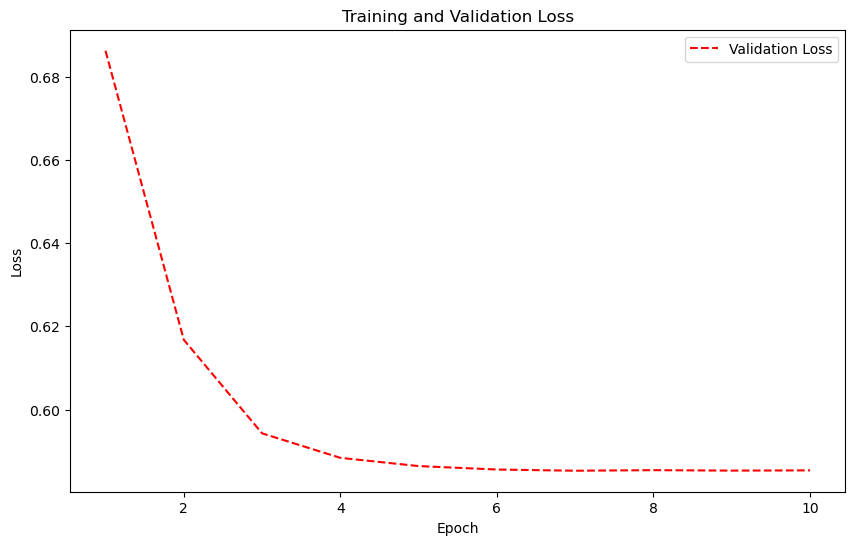

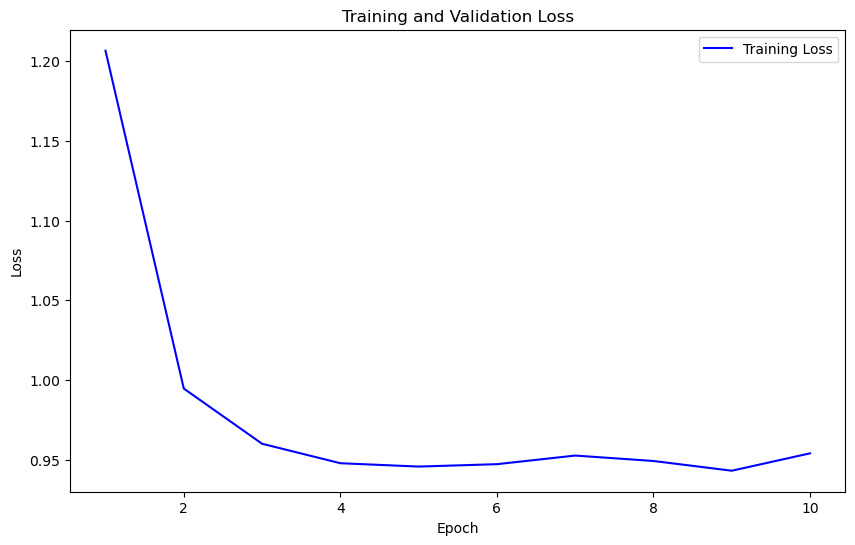

In [64]:
import matplotlib.pyplot as plt

#train_loss = [1.206400,0.994700 ,0.960100,0.947900 ,0.945800, 0.947300, 0.952700, 0.949300, 0.943200, 0.954100]
val_loss = [0.686242, 0.616763, 0.594273,0.588383 ,0.586404 ,0.585576 ,0.585289 ,0.585424 ,0.585315, 0.585372]   

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
#plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_loss = [1.206400,0.994700 ,0.960100,0.947900 ,0.945800, 0.947300, 0.952700, 0.949300, 0.943200, 0.954100]
#val_loss = [0.686242, 0.616763, 0.594273,0.588383 ,0.586404 ,0.585576 ,0.585289 ,0.585424 ,0.585315, 0.585372]   

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
#plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
model.to(device)
predictions = []
for i in range(50): 
    input_ids = torch.tensor(tokenized_datasets['test'][i]['input_ids']).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model.generate(input_ids, max_new_tokens = 50)
    
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(decoded_output)

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=predictions,
    references=decoded_references[0:len(predictions)],
    use_aggregator=True,
    use_stemmer=True,
)

print('Finetuned model:')
print(original_model_results)

Finetuned model:
{'rouge1': 0.12597661433229349, 'rouge2': 0.012656723756400083, 'rougeL': 0.09579829878094408, 'rougeLsum': 0.09570397047301635}


In [69]:
for i in range (50):
    print(f"row: {i}")
    print(predictions[i])
    print("")
    print(decoded_references[i])
    print("")

row: 0
Cardiac pulmonary hypertension, Hypercholesterolemia, Hypercholesterolemia,, Cardiac thrombosis,, Cardiac angiosclerosis, Hypercholesterolemia,, Cardiac artery, Cardiac, Cardiac thromboembolic heart failure,, Cardiac ischemia,, Cardiac isch

Subendocardial infarction, initial episode of care, Coronary atherosclerosis of native coronary artery, Esophageal reflux, Pure hypercholesterolemia, Unspecified essential hypertension, Atrial fibrillation, Schizoaffective disorder, chronic

row: 1
Cardiac, Cardiac inflammation, and steroid use, affluejo, affluejo, affluejovate, affluejovate, affluejovate, affluejovate, affluejovate, affluejovate, affluejovate, afflue

Coronary atherosclerosis of native coronary artery, Pure hypercholesterolemia, Esophagitis, unspecified, Chronic duodenal ulcer without mention of hemorrhage or perforation, without mention of obstruction

row: 2
Primary ovarian cancer, Hypertension, Untreated, Untreated, Hypertension, Hypertension, Hypertension, Hypertension,

In [ ]:
# evaluating with rouge_score

### end fine-tuning

# parameter efficient fine tuning

In [70]:
from peft import LoraConfig, get_peft_model

model_name='/kaggle/input/flan-t5/pytorch/base/4'
model_name = "google/flan-t5-base"
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name,
                                                       torch_dtype=torch.bfloat16,
                                                       cache_dir="/nfs/home/aliami/hugging_cache/"
                                                      )
tokenizer = AutoTokenizer.from_pretrained(model_name)

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q", "v"],
    lora_dropout=0.01,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)

In [71]:
peft_model = get_peft_model(original_model, config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 884736
all model parameters: 248462592
percentage of trainable model parameters: 0.36%


In [72]:
training_args = TrainingArguments(
    output_dir="C:/Users/danie/Documents/SKOLA/output",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir="C:/Users/danie/Documents/SKOLA/logs",
    evaluation_strategy="epoch",
)

tensorboard_callback = TensorBoardCallback()

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    callbacks=[tensorboard_callback]  
)

eval_results = trainer.evaluate()
print(f"Initial evaluation loss: {eval_results['eval_loss']}")

trainer.train()

You are adding a <class 'transformers.integrations.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback


Initial evaluation loss: 43.46983337402344


Epoch,Training Loss,Validation Loss
1,2.190300,1.073802
2,1.402800,0.856500
3,1.366600,0.837641
4,1.348400,0.831935
5,1.350400,0.830758
6,1.363000,0.830521
7,1.354000,0.830443
8,1.350000,0.830232
9,1.343100,0.830409
10,1.362400,0.830370


TrainOutput(global_step=15000, training_loss=1.9388598958333334, metrics={'train_runtime': 6759.0983, 'train_samples_per_second': 8.877, 'train_steps_per_second': 2.219, 'total_flos': 4.12485156864e+16, 'train_loss': 1.9388598958333334, 'epoch': 10.0})

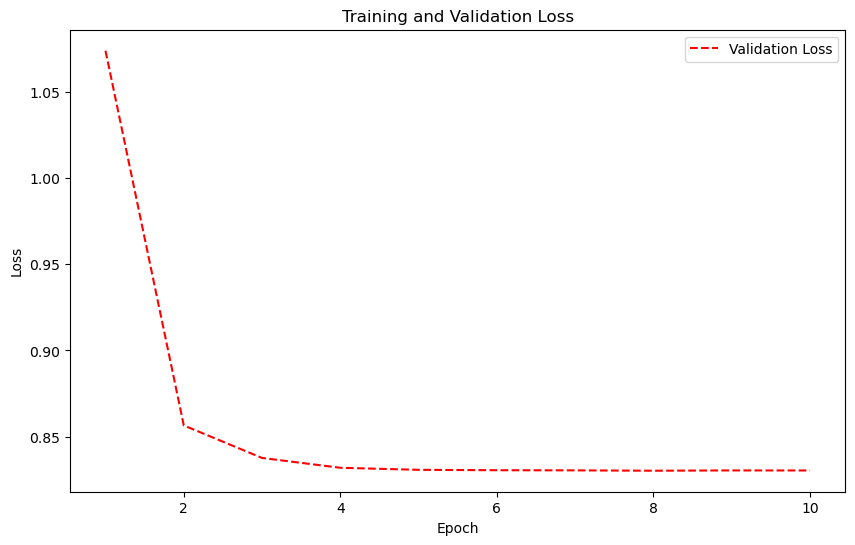

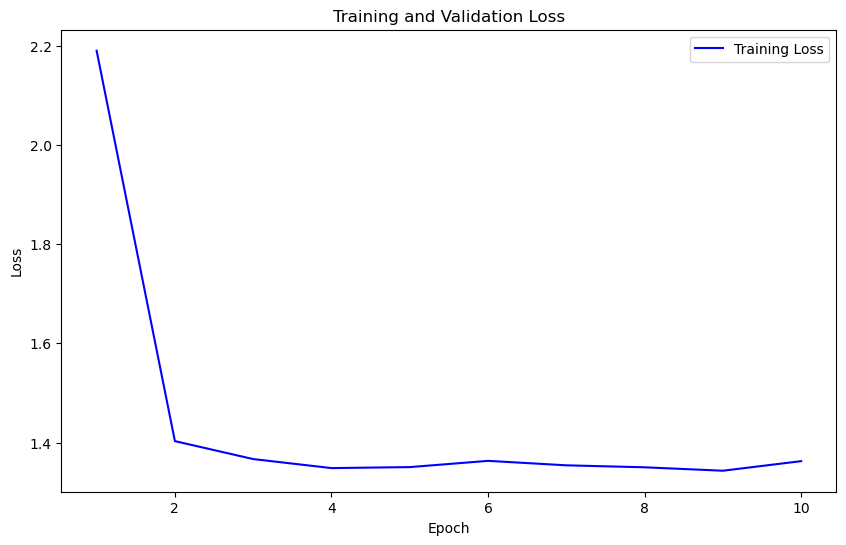

In [73]:
import matplotlib.pyplot as plt

#train_loss = [2.190300,1.402800,1.366600,1.348400,1.350400,1.363000,1.354000,1.350000,1.343100,1.362400]
val_loss = [1.073802,0.856500,0.837641,0.831935,0.830758,0.830521,0.830443,0.830232,0.830409,0.830370]   

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
#plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_loss = [2.190300,1.402800,1.366600,1.348400,1.350400,1.363000,1.354000,1.350000,1.343100,1.362400]
#val_loss = [1.073802,0.856500,0.837641,0.831935,0.830758,0.830521,0.830443,0.830232,0.830409,0.830370]  

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
#plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
peft_model.to(device)
predictions = []
for i in range(50): 
    input_ids = torch.tensor(tokenized_datasets['test'][i]['input_ids']).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = peft_model.generate(input_ids=input_ids)
    
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(decoded_output)

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=predictions,
    references=decoded_references[0:len(predictions)],
    use_aggregator=True,
    use_stemmer=True,
)

eval_results = trainer.evaluate()
print(f"Initial evaluation loss: {eval_results['eval_loss']}")

print('PEFT model:')
print(original_model_results)

### end PEFT

In [ ]:
for i in range (50):
    print(f"row: {i}")
    print(predictions[i])
    print("")
    print(decoded_references[i])
    print("")